In [1]:
import numpy as np
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
import shutil
import cv2

In [2]:
labels_dir = "/kaggle/input/solar-panels-in-satellite-imagery/labels-20250212T103318Z-001/labels/labels_native"

img_dir = "/kaggle/input/solar-panels-in-satellite-imagery/image_chips_native-20250212T103727Z-001/image_chips_native"

output_dir = "/kaggle/working/solar_dataset"

# Data Exploration and Understanding

100%|██████████| 2542/2542 [00:13<00:00, 184.43it/s]


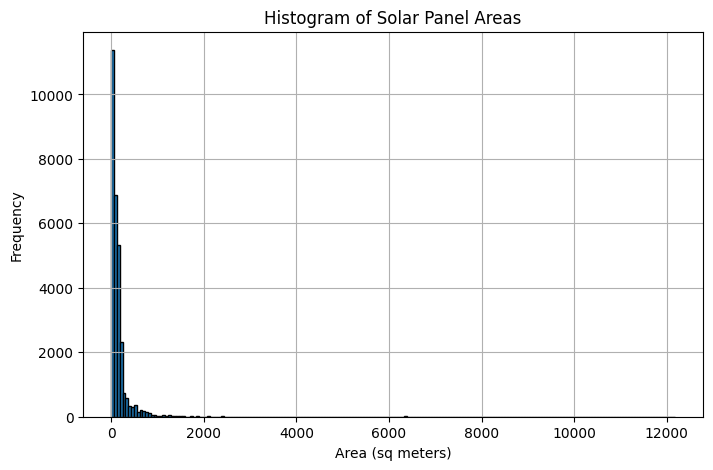

In [3]:
NATIVE_SIZE = 416  
PIXEL_SIZE = 0.31

label_files = [f for f in os.listdir(labels_dir) if f.endswith(".txt")]

# Count total instances of solar panels
total_instances = 0
label_counts = []
areas = []

for file in tqdm(label_files):
    with open(os.path.join(labels_dir, file), 'r') as f:
        lines = f.readlines()
        total_instances += len(lines)
        label_counts.append(len(lines))
        
        # Calculate area in square meters
        for line in lines:
            _, x_center, y_center, x_width, y_width = map(float, line.strip().split())
            width_meters = x_width * NATIVE_SIZE * PIXEL_SIZE
            height_meters = y_width * NATIVE_SIZE * PIXEL_SIZE
            area = width_meters * height_meters
            areas.append(area)


label_counts_series = pd.Series(label_counts)

mean_area = np.mean(areas)
std_area = np.std(areas)

plt.figure(figsize=(8, 5))
plt.hist(areas, bins=200, edgecolor='black')
plt.xlabel("Area (sq meters)")
plt.ylabel("Frequency")
plt.title("Histogram of Solar Panel Areas")
plt.grid()
plt.show()

In [4]:
# Print results
print(f"Total instances of solar panels: {total_instances}")
print("Label count distribution:")
print(label_counts_series.value_counts().sort_index())
print(f"Mean area: {mean_area:.2f} sq meters")
print(f"Standard deviation of area: {std_area:.2f} sq meters")

Total instances of solar panels: 29625
Label count distribution:
1      81
2     167
3     221
4     218
5     217
     ... 
74      5
75      1
76      2
77      2
78      1
Name: count, Length: 74, dtype: int64
Mean area: 191.52 sq meters
Standard deviation of area: 630.70 sq meters


In [5]:
"""To compute the area (in meters) for a single solar panel instance, we first convert the native image value labels to pixels through these transforms:
x_center_pixel = x_center * 416
y_center_pixel = y_center * 416
width_pixel = x_width * 416
height_pixel = y_width * 416

because the native images are 416*416 pixels.

To convert to real-world meter values, we use the dataset's provided geotransform ie, 1 pixel is equivalent to 0.31 meters. Hence:
width_meters = width_pixel * 0.31
height_meters = height_pixel * 0.31
area_meters = width_meters * height_meters


Upon plotting the histogram, we observe that most solar panels have areas around 200 sq meters, with the mean being 191.52 sq meters and std being 630.7 sq meters

"""

"To compute the area (in meters) for a single solar panel instance, we first convert the native image value labels to pixels through these transforms:\nx_center_pixel = x_center * 416\ny_center_pixel = y_center * 416\nwidth_pixel = x_width * 416\nheight_pixel = y_width * 416\n\nbecause the native images are 416*416 pixels.\n\nTo convert to real-world meter values, we use the dataset's provided geotransform ie, 1 pixel is equivalent to 0.31 meters. Hence:\nwidth_meters = width_pixel * 0.31\nheight_meters = height_pixel * 0.31\narea_meters = width_meters * height_meters\n\n\nUpon plotting the histogram, we observe that most solar panels have areas around 200 sq meters, with the mean being 191.52 sq meters and std being 630.7 sq meters\n\n"

# Implementing the Fundamental Functions

1. IoU

In [6]:
pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
import shapely
import supervision as sv

In [8]:
def create_bb_shapely(x_center, y_center, width, height, img_size=416):
    x_b = (x_center - width / 2) * img_size
    y_b = (y_center - height / 2) * img_size
    x_t = (x_center + width / 2) * img_size
    y_t = (y_center + height / 2) * img_size

    return shapely.geometry.box(x_b, y_b, x_t, y_t)

def calculate_iou_shapely(box1, box2, img_size = 416):
    b1 = create_bb_shapely(*box1, img_size)
    b2 = create_bb_shapely(*box2, img_size)

    i = b1.intersection(b2).area
    u = b1.union(b2).area

    return i / u if u > 0 else 0.0

In [9]:
def yolo_to_xyxy(box, image_size=416):
    x_center, y_center, width, height = box
    x_center_abs = x_center * image_size
    y_center_abs = y_center * image_size
    width_abs = width * image_size
    height_abs = height * image_size

    x_min = x_center_abs - (width_abs / 2)
    y_min = y_center_abs - (height_abs / 2)
    x_max = x_center_abs + (width_abs / 2)
    y_max = y_center_abs + (height_abs / 2)

    return x_min, y_min, x_max, y_max

def calculate_iou_supervision(box1, box2, image_size=416):
    box1_xyxy = yolo_to_xyxy(box1, image_size=image_size)
    box2_xyxy = yolo_to_xyxy(box2, image_size=image_size)
    boxes_true = np.array([box1_xyxy])
    boxes_pred = np.array([box2_xyxy])
    iou_matrix = sv.box_iou_batch(boxes_true, boxes_pred)
    return iou_matrix[0, 0]

In [10]:
# Sample bounding boxes in YOLOv4 format
box1 = (0.5, 0.5, 0.4, 0.3)  
box2 = (0.55, 0.55, 0.35, 0.25)

iou_shapely = calculate_iou_shapely(box1, box2)
print(f"IoU using Shapely: {iou_shapely:.4f}")

iou_supervision = calculate_iou_supervision(box1, box2)
print(f"IoU using Supervision: {iou_supervision:.4f}")

IoU using Shapely: 0.5442
IoU using Supervision: 0.5442


2. Average Precision (AP)

In [11]:
def compute_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5):
    tp, fp, fn = 0, 0, len(gt_boxes)
    pred_boxes_sorted = sorted(pred_boxes, key=lambda x: x[1], reverse=True)
    precisions, recalls = [], []
    
    for pred_box, _ in pred_boxes_sorted:
        max_iou = max((calculate_iou_shapely(pred_box, gt) for gt in gt_boxes), default=0)
        if max_iou >= iou_threshold:
            tp += 1
            fn -= 1
        else:
            fp += 1
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
    
    return np.array(precisions), np.array(recalls)

In [12]:
def compute_ap_voc11(precisions, recalls):
    ap = 0.0
    for t in np.linspace(0, 1, 11):
        max_prec = max(precisions[recalls >= t]) if np.any(recalls >= t) else 0
        ap += max_prec
    return ap / 11

In [13]:
def compute_ap_coco101(precisions, recalls):
    ap = 0.0
    for t in np.linspace(0, 1, 101):
        max_prec = max(precisions[recalls >= t]) if np.any(recalls >= t) else 0
        ap += max_prec
    return ap / 101

In [14]:
def compute_ap_auc(precisions, recalls):
    ap = 0.0
    for i in range(1, len(recalls)):
        delta_recall = recalls[i] - recalls[i - 1]  
        ap += precisions[i] * delta_recall  

    return ap


In [15]:
def generate_random_boxes(num_boxes=10, img_size=100, box_size=20):
    return [(np.random.randint(0, img_size - box_size),
             np.random.randint(0, img_size - box_size),
             np.random.randint(0, img_size - box_size) + box_size,
             np.random.randint(0, img_size - box_size) + box_size) for _ in range(num_boxes)]

np.random.seed(25)
num_images = 10
all_ap_voc11, all_ap_coco101, all_ap_auc = [], [], []

for _ in range(num_images):
    gt_boxes = generate_random_boxes()
    pred_boxes = [(box, np.random.rand()) for box in generate_random_boxes()]  
    precisions, recalls = compute_precision_recall(gt_boxes, pred_boxes)
    
    ap_voc11 = compute_ap_voc11(precisions, recalls)
    ap_coco101 = compute_ap_coco101(precisions, recalls)
    ap_auc = compute_ap_auc(precisions, recalls)
    
    all_ap_voc11.append(ap_voc11)
    all_ap_coco101.append(ap_coco101)
    all_ap_auc.append(ap_auc)

# Display results
print(f"Mean AP50 (VOC 11-point): {np.mean(all_ap_voc11):.4f}")
print(f"Mean AP50 (COCO 101-point): {np.mean(all_ap_coco101):.4f}")
print(f"Mean AP50 (AUC PR): {np.mean(all_ap_auc):.4f}")

Mean AP50 (VOC 11-point): 0.1611
Mean AP50 (COCO 101-point): 0.1312
Mean AP50 (AUC PR): 0.0694


In [16]:
""" 
Comparing the avg precision at a threshold of 0.5, we observe that the AUC PR method gives the lowest AP, followed by COCO-101 point interpolation and finally VOC-11 point interpolation. 
"""

' \nComparing the avg precision at a threshold of 0.5, we observe that the AUC PR method gives the lowest AP, followed by COCO-101 point interpolation and finally VOC-11 point interpolation. \n'

# Model Building and Evaluation

In [17]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 17.8 MB/s eta 0:00:00


In [18]:
os.makedirs(f"{output_dir}/images/train", exist_ok=True)
os.makedirs(f"{output_dir}/images/val", exist_ok=True)
os.makedirs(f"{output_dir}/images/test", exist_ok=True)
os.makedirs(f"{output_dir}/labels/train", exist_ok=True)
os.makedirs(f"{output_dir}/labels/val", exist_ok=True)
os.makedirs(f"{output_dir}/labels/test", exist_ok=True)

In [19]:
image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".tif")])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith(".txt")])

In [20]:
# Making 70, 10, 20 split for training, validation and testing
train_images, test_images = train_test_split(image_files, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)

In [21]:
def move_files(files, src_img, src_lbl, dest_img, dest_lbl):
    for file in files:
        shutil.copy(os.path.join(src_img, file), os.path.join(dest_img, file))
        lbl_file = file.replace(".tif", ".txt")
        if lbl_file in label_files:
            shutil.copy(os.path.join(src_lbl, lbl_file), os.path.join(dest_lbl, lbl_file))

move_files(train_images, img_dir, labels_dir, f"{output_dir}/images/train", f"{output_dir}/labels/train")
move_files(val_images, img_dir, labels_dir, f"{output_dir}/images/val", f"{output_dir}/labels/val")
move_files(test_images, img_dir, labels_dir, f"{output_dir}/images/test", f"{output_dir}/labels/test")

In [22]:
dataset_yaml = f"""path: {output_dir}
train: images/train
val: images/val
test: images/test
nc: 3
names: ['high', 'moderate', 'low']
"""

with open(f"{output_dir}/dataset.yaml", "w") as f:
    f.write(dataset_yaml)


In [23]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  
model.train(data=f"{output_dir}/dataset.yaml", epochs=50, imgsz=416)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 85.7MB/s]


Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/solar_dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/solar_dataset/labels/train... 1828 images, 9 backgrounds, 0 corrupt: 100%|██████████| 1837/1837 [00:02<00:00, 693.76it/s]


train: New cache created: /kaggle/working/solar_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/solar_dataset/labels/val... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<00:00, 686.83it/s]


val: New cache created: /kaggle/working/solar_dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.53G      1.905      2.248      1.321        292        416: 100%|██████████| 115/115 [00:13<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        205       2408      0.889      0.189      0.204      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.12G       1.58      1.236      1.141        214        416: 100%|██████████| 115/115 [00:11<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]

                   all        205       2408      0.856       0.21       0.19      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.23G      1.484      1.096      1.103        152        416: 100%|██████████| 115/115 [00:11<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]

                   all        205       2408      0.921      0.239      0.263      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.29G       1.42      1.027      1.081        313        416: 100%|██████████| 115/115 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]

                   all        205       2408      0.926      0.249      0.275      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.22G      1.362     0.9583       1.07        212        416: 100%|██████████| 115/115 [00:11<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]

                   all        205       2408      0.922      0.251      0.274      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.21G      1.308      0.898      1.043        172        416: 100%|██████████| 115/115 [00:11<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]

                   all        205       2408      0.934      0.262      0.294      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.31G      1.307     0.8959      1.041        293        416: 100%|██████████| 115/115 [00:11<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]

                   all        205       2408      0.937      0.271      0.393      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       1.1G      1.276     0.8547      1.027        182        416: 100%|██████████| 115/115 [00:11<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]

                   all        205       2408      0.949      0.267      0.355      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.19G      1.286     0.8487      1.025        164        416: 100%|██████████| 115/115 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]

                   all        205       2408      0.665      0.428      0.413      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.62G      1.229     0.8055      1.011        211        416: 100%|██████████| 115/115 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]

                   all        205       2408      0.668       0.41        0.4       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.32G      1.217      0.791      1.006        125        416: 100%|██████████| 115/115 [00:11<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]

                   all        205       2408      0.831      0.427      0.457      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.22G      1.195     0.7763      1.003         95        416: 100%|██████████| 115/115 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]

                   all        205       2408      0.863      0.439      0.479       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.23G      1.179     0.7552     0.9954        310        416: 100%|██████████| 115/115 [00:11<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]

                   all        205       2408      0.852      0.408      0.459      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.19G       1.18     0.7513     0.9945        131        416: 100%|██████████| 115/115 [00:11<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]

                   all        205       2408       0.86      0.455      0.488      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.27G      1.169     0.7514     0.9901        147        416: 100%|██████████| 115/115 [00:11<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]

                   all        205       2408      0.828      0.433      0.467      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.24G      1.163     0.7384     0.9884        290        416: 100%|██████████| 115/115 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]

                   all        205       2408      0.847       0.45      0.506      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.34G      1.152     0.7261     0.9859        206        416: 100%|██████████| 115/115 [00:11<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]

                   all        205       2408      0.944       0.47      0.533      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.14G      1.132     0.7052     0.9744        175        416: 100%|██████████| 115/115 [00:11<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]

                   all        205       2408      0.862      0.531      0.559      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.21G      1.115     0.7011     0.9721        263        416: 100%|██████████| 115/115 [00:11<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]

                   all        205       2408      0.846      0.515      0.567      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.17G      1.109     0.7053     0.9685        152        416: 100%|██████████| 115/115 [00:11<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]

                   all        205       2408      0.923      0.521       0.58      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.08G      1.117     0.6967     0.9694        241        416: 100%|██████████| 115/115 [00:11<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]

                   all        205       2408      0.824      0.443      0.533      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.42G      1.087     0.6866     0.9686        128        416: 100%|██████████| 115/115 [00:11<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]

                   all        205       2408      0.626      0.509      0.391      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.36G      1.075      0.692     0.9593        289        416: 100%|██████████| 115/115 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]

                   all        205       2408      0.154      0.257      0.236      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.26G      1.093     0.6944      0.966        133        416: 100%|██████████| 115/115 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]

                   all        205       2408      0.882      0.458      0.513      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.11G      1.061     0.6856     0.9554        154        416: 100%|██████████| 115/115 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]

                   all        205       2408      0.522       0.29      0.373      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.25G      1.054     0.6819     0.9567        269        416: 100%|██████████| 115/115 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]

                   all        205       2408      0.784       0.41      0.436      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.23G      1.061     0.6796     0.9529        151        416: 100%|██████████| 115/115 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]

                   all        205       2408      0.896      0.461      0.504      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.29G      1.063     0.6773     0.9516        133        416: 100%|██████████| 115/115 [00:11<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]

                   all        205       2408       0.96      0.516       0.56      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.15G      1.049     0.6727     0.9516        173        416: 100%|██████████| 115/115 [00:11<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.58it/s]

                   all        205       2408      0.891      0.514      0.545      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.38G      1.031     0.6542     0.9451        169        416: 100%|██████████| 115/115 [00:11<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]

                   all        205       2408      0.949      0.466      0.563      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.34G       1.04     0.6642      0.948        121        416: 100%|██████████| 115/115 [00:11<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.61it/s]

                   all        205       2408      0.946      0.492      0.561      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.56G      1.021     0.6493     0.9398        272        416: 100%|██████████| 115/115 [00:11<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]

                   all        205       2408      0.924      0.501      0.555      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.36G      1.015     0.6445      0.941        138        416: 100%|██████████| 115/115 [00:11<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]

                   all        205       2408      0.876      0.569       0.57      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.35G     0.9976     0.6343     0.9341        137        416: 100%|██████████| 115/115 [00:11<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]

                   all        205       2408      0.898      0.542      0.592      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.25G     0.9972     0.6355      0.934        177        416: 100%|██████████| 115/115 [00:11<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]

                   all        205       2408      0.965      0.526      0.581      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.13G      1.002     0.6374     0.9332        186        416: 100%|██████████| 115/115 [00:11<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]

                   all        205       2408      0.956      0.516      0.596      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       1.3G     0.9959     0.6328     0.9341        126        416: 100%|██████████| 115/115 [00:11<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]

                   all        205       2408      0.915      0.512      0.559       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.35G     0.9901      0.626     0.9295        165        416: 100%|██████████| 115/115 [00:11<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.80it/s]

                   all        205       2408      0.918       0.54      0.568      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.19G     0.9712     0.6142     0.9245        152        416: 100%|██████████| 115/115 [00:11<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]

                   all        205       2408      0.944      0.523      0.568      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.25G     0.9742     0.6169     0.9267        130        416: 100%|██████████| 115/115 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.68it/s]

                   all        205       2408      0.934      0.532      0.596      0.428


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.22G     0.9215     0.5916     0.9081        125        416: 100%|██████████| 115/115 [00:11<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]

                   all        205       2408      0.919      0.544      0.611      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.17G     0.8904     0.5663     0.9031        118        416: 100%|██████████| 115/115 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]

                   all        205       2408      0.935      0.533       0.62      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.21G     0.8768     0.5521     0.8968        139        416: 100%|██████████| 115/115 [00:11<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]

                   all        205       2408      0.913      0.548       0.65      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.27G     0.8767      0.558     0.8986        130        416: 100%|██████████| 115/115 [00:11<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]

                   all        205       2408      0.962      0.533      0.662      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.12G     0.8639     0.5467     0.8962        141        416: 100%|██████████| 115/115 [00:11<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]

                   all        205       2408      0.932       0.54      0.638      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.973G     0.8568     0.5397     0.8938        103        416: 100%|██████████| 115/115 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]

                   all        205       2408      0.676      0.657      0.691      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.29G     0.8368     0.5318     0.8901        146        416: 100%|██████████| 115/115 [00:11<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]

                   all        205       2408      0.947      0.537      0.688      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.19G      0.843     0.5336     0.8905        111        416: 100%|██████████| 115/115 [00:11<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]

                   all        205       2408      0.726      0.673      0.718      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.02G     0.8332     0.5268     0.8881        150        416: 100%|██████████| 115/115 [00:11<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]

                   all        205       2408      0.799      0.677      0.742      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.05G     0.8256     0.5218     0.8858        170        416: 100%|██████████| 115/115 [00:11<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]

                   all        205       2408      0.709      0.658      0.725      0.554



50 epochs completed in 0.186 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


                   all        205       2408      0.787      0.677      0.742      0.564
                  high        203       2372      0.795       0.96      0.964      0.757
              moderate         10         15          1      0.261      0.449      0.379
                   low         13         21      0.566       0.81      0.812      0.558


Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bf1d1ffb6d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04


image 1/1 /kaggle/working/solar_dataset/images/test/solarpanels_native_3__x0_7383_y0_9528_dxdy_416.tif: 416x416 6 highs, 6.6ms
Speed: 0.8ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


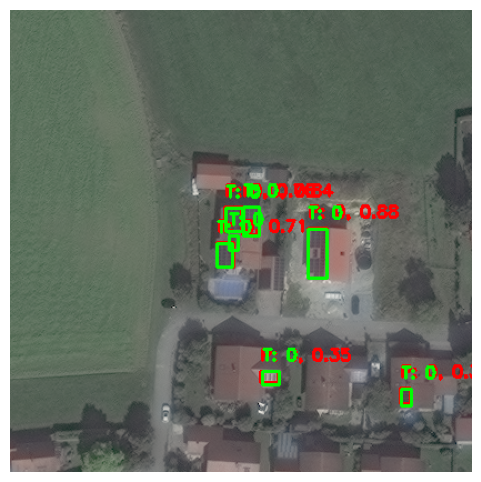


image 1/1 /kaggle/working/solar_dataset/images/test/solarpanels_native_3__x0_14309_y0_7792_dxdy_416.tif: 416x416 8 highs, 9.2ms
Speed: 1.1ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)


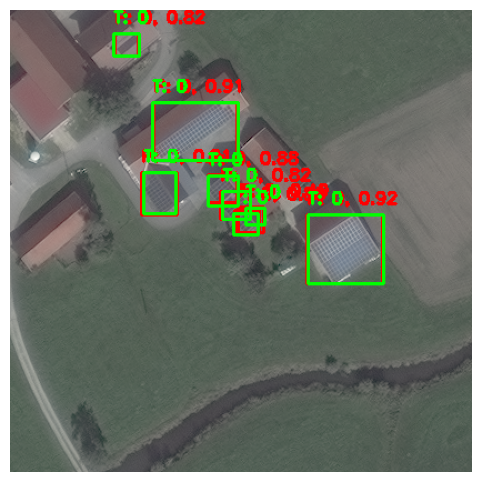


image 1/1 /kaggle/working/solar_dataset/images/test/solarpanels_native_1__x0_2722_y0_10074_dxdy_416.tif: 416x416 10 highs, 7.3ms
Speed: 0.9ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)


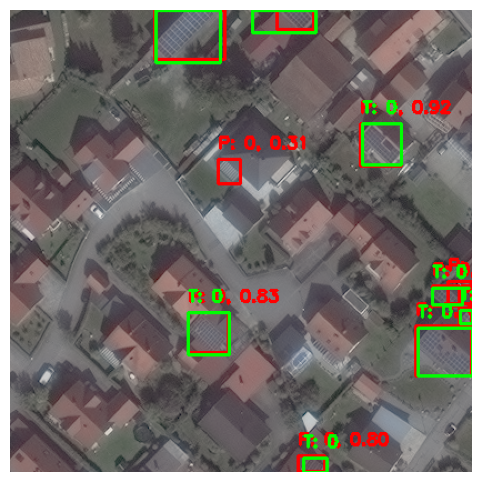


image 1/1 /kaggle/working/solar_dataset/images/test/solarpanels_native_1__x0_3192_y0_7793_dxdy_416.tif: 416x416 6 highs, 8.7ms
Speed: 1.0ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)


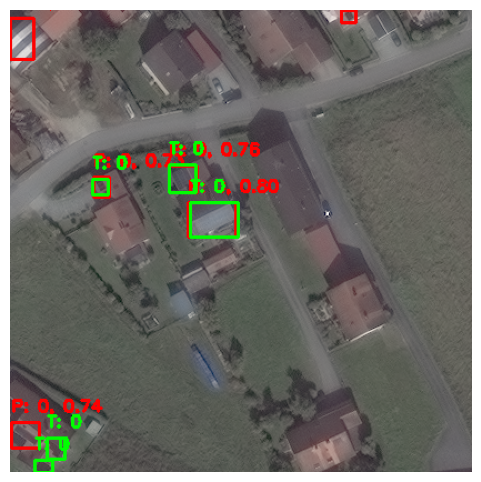

In [24]:
test_images = os.listdir(f"{output_dir}/images/test")

for img_name in test_images[:4]:  
    img_path = f"{output_dir}/images/test/{img_name}"
    label_path = f"{output_dir}/labels/test/{img_name.replace('.tif', '.txt')}" 
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = model(img_path)

    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        conf = box.conf[0].item()
        cls = int(box.cls[0].item())
        color = (255, 0, 0)  # Red for predictions
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        cv2.putText(img, f"P: {cls}, {conf:.2f}", (int(x1), int(y1)-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                cls, x_center, y_center, w, h = map(float, parts)
                img_h, img_w, _ = img.shape
                x1 = int((x_center - w / 2) * img_w)
                y1 = int((y_center - h / 2) * img_h)
                x2 = int((x_center + w / 2) * img_w)
                y2 = int((y_center + h / 2) * img_h)

                color = (0, 255, 0)  # Green for ground truth
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(img, f"T: {int(cls)}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [25]:
metrics = model.val()

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /kaggle/working/solar_dataset/labels/val.cache... 205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.76it/s]


                   all        205       2408      0.799      0.677      0.743      0.558
                  high        203       2372      0.799      0.961      0.965      0.757
              moderate         10         15          1       0.26      0.448      0.377
                   low         13         21      0.596       0.81      0.815      0.539


Speed: 0.7ms preprocess, 3.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train2


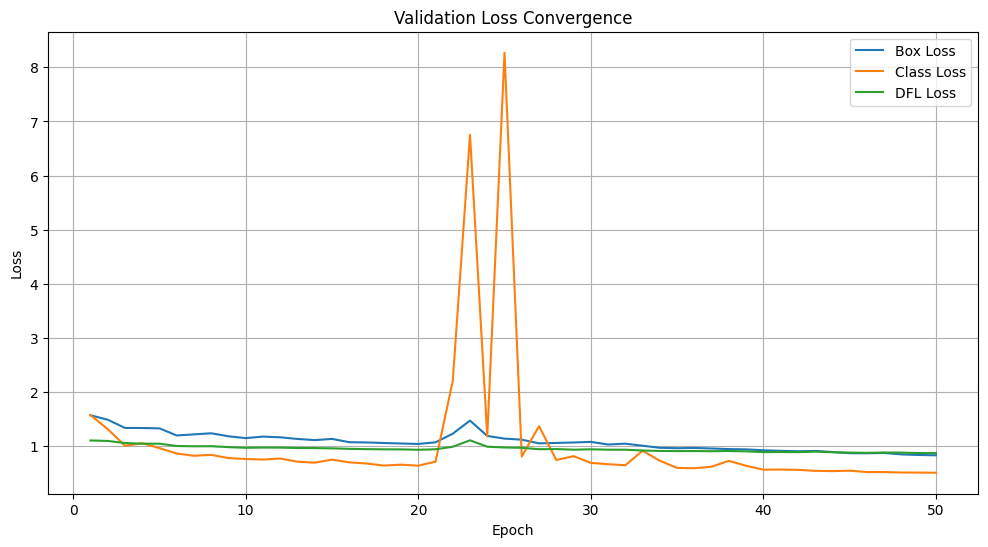

In [26]:
from pathlib import Path
csv_path = Path('runs/detect/train/results.csv')  
history = pd.read_csv(csv_path)

plt.figure(figsize=(12, 6))

# Plot each loss component
plt.plot(history['epoch'], history['val/box_loss'], label='Box Loss')
plt.plot(history['epoch'], history['val/cls_loss'], label='Class Loss')
plt.plot(history['epoch'], history['val/dfl_loss'], label='DFL Loss')

plt.title('Validation Loss Convergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
results = model("/kaggle/working/solar_dataset/images/test")  

predictions = {}

for result in results:
    img_id = result.path.split("/")[-1] 
    preds = []
    for box in result.boxes.data:
        x1, y1, x2, y2, conf = box[:5].tolist()
        preds.append([x1, y1, x2, y2, conf])
    predictions[img_id] = preds

labels_dir = "/kaggle/working/solar_dataset/labels/test"
ground_truths = {}

for label_file in os.listdir(labels_dir):
    img_id = label_file.replace(".txt", ".tif") 
    gt_boxes = []
    
    with open(os.path.join(labels_dir, label_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.split())
            x1 = (x_center - width / 2) * 416  
            y1 = (y_center - height / 2) * 416
            x2 = (x_center + width / 2) * 416
            y2 = (y_center + height / 2) * 416
            
            gt_boxes.append([x1, y1, x2, y2])
    
    ground_truths[img_id] = gt_boxes


image 1/511 /kaggle/working/solar_dataset/images/test/solarpanels_native_1__x0_1016_y0_6504_dxdy_416.tif: 416x416 7 highs, 8.0ms
image 2/511 /kaggle/working/solar_dataset/images/test/solarpanels_native_1__x0_10313_y0_12985_dxdy_416.tif: 416x416 6 highs, 6.4ms
image 3/511 /kaggle/working/solar_dataset/images/test/solarpanels_native_1__x0_10336_y0_10994_dxdy_416.tif: 416x416 3 highs, 6.1ms
image 4/511 /kaggle/working/solar_dataset/images/test/solarpanels_native_1__x0_10683_y0_744_dxdy_416.tif: 416x416 6 highs, 6.3ms
image 5/511 /kaggle/working/solar_dataset/images/test/solarpanels_native_1__x0_1073_y0_8078_dxdy_416.tif: 416x416 8 highs, 6.2ms
image 6/511 /kaggle/working/solar_dataset/images/test/solarpanels_native_1__x0_1081_y0_8886_dxdy_416.tif: 416x416 12 highs, 6.2ms
image 7/511 /kaggle/working/solar_dataset/images/test/solarpanels_native_1__x0_1084_y0_8849_dxdy_416.tif: 416x416 13 highs, 6.3ms
image 8/511 /kaggle/working/solar_dataset/images/test/solarpanels_native_1__x0_1095_y0_778

In [28]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection
    
    return intersection / union if union > 0 else 0

def evaluate_model(predictions, ground_truths, iou_thresholds, conf_thresholds):
    results = np.zeros((len(iou_thresholds), len(conf_thresholds), 3))  
    
    for i, iou_thresh in enumerate(iou_thresholds):
        for j, conf_thresh in enumerate(conf_thresholds):
            TP, FP, FN = 0, 0, 0
            
            for img_id in predictions.keys():
                pred_boxes = [box for box in predictions[img_id] if box[4] >= conf_thresh]  
                gt_boxes = ground_truths.get(img_id, [])
                
                matched = set()
                for pred in pred_boxes:
                    best_iou = 0
                    best_gt_idx = -1
                    for idx, gt in enumerate(gt_boxes):
                        iou = compute_iou(pred[:4], gt[:4])  
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = idx
                    
                    if best_iou >= iou_thresh and best_gt_idx not in matched:
                        TP += 1
                        matched.add(best_gt_idx)
                    else:
                        FP += 1
                
                FN += len(gt_boxes) - len(matched)
            
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            results[i, j] = [precision, recall, f1]
    
    return results

iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
conf_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
results = evaluate_model(predictions, ground_truths, iou_thresholds, conf_thresholds)
print(results)


[[[    0.87194     0.95604     0.91205]
  [    0.89016     0.94956      0.9189]
  [    0.95641     0.90908     0.93214]
  [    0.99282     0.78716     0.87811]
  [    0.99692     0.25585      0.4072]]

 [[    0.87035      0.9543     0.91039]
  [    0.88882     0.94813     0.91752]
  [    0.95558     0.90829     0.93133]
  [    0.99222     0.78669     0.87758]
  [    0.99692     0.25585      0.4072]]

 [[    0.86444     0.94782     0.90421]
  [    0.88319     0.94213     0.91171]
  [    0.95076      0.9037     0.92663]
  [    0.98983     0.78479     0.87546]
  [     0.9963     0.25569     0.40695]]

 [[    0.82795     0.90781     0.86604]
  [    0.84658     0.90307     0.87391]
  [    0.91965     0.87413     0.89631]
  [    0.97706     0.77467     0.86417]
  [     0.9963     0.25569     0.40695]]

 [[    0.43582     0.47786     0.45588]
  [    0.44723     0.47707     0.46167]
  [    0.49925     0.47454     0.48658]
  [    0.57738     0.45778     0.51067]
  [    0.89094     0.22865     0